In [2]:
#Para a solução do problema foram utilizadas apenas as bibliotecas Numpy para os cálculos e Matplotlib para a plotagem dos resultados
#%pip install --upgrade numpy matplotlib pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [10]:
#Dados fornecidos no enunciado
Lx = 1 #dimensão em x
Ly = 1 #dimensão em y
k = 1 #W/mk
NVRx = 11 #quantidade de volumes reais em x
NVRy = 11 #quantidade de volumes reais em y
Nx = NVRx + 2 #quantidade de volumes de controle em x considerando os volumes fictícios
Ny = NVRy + 2 #quantidade de volumes de controle em y considerando os volumes fictícios
qtdadeVolumes = Nx * Ny #quantidade total de volumes de controle
deltaX = Lx / NVRx #distância do centro de um volume ao outro em x
deltaY = Ly / NVRy #distância do centro de um volume ao outro em y

x = np.linspace(deltaX/2, Lx - deltaX/2, NVRx) #coordenadas dos centros dos volumes de controle em x
y = np.linspace(deltaY/2, Ly - deltaY/2, NVRy) #coordenadas dos centros dos volumes de controle em y
Tx1 = np.sin(np.pi * x) #temperatura na parede superior
T0y = 0 #temperatura na parede esquerda
T1y = 0 #temperatura na parede direita
Tx0 = 0 #temperatura na parede inferior

print('x = ', x, '\n'
      'y = ', y, '\n'
      'Tx1 = ', Tx1)

x =  [0.04545455 0.13636364 0.22727273 0.31818182 0.40909091 0.5
 0.59090909 0.68181818 0.77272727 0.86363636 0.95454545] 
y =  [0.04545455 0.13636364 0.22727273 0.31818182 0.40909091 0.5
 0.59090909 0.68181818 0.77272727 0.86363636 0.95454545] 
Tx1 =  [0.14231484 0.41541501 0.65486073 0.84125353 0.95949297 1.
 0.95949297 0.84125353 0.65486073 0.41541501 0.14231484]


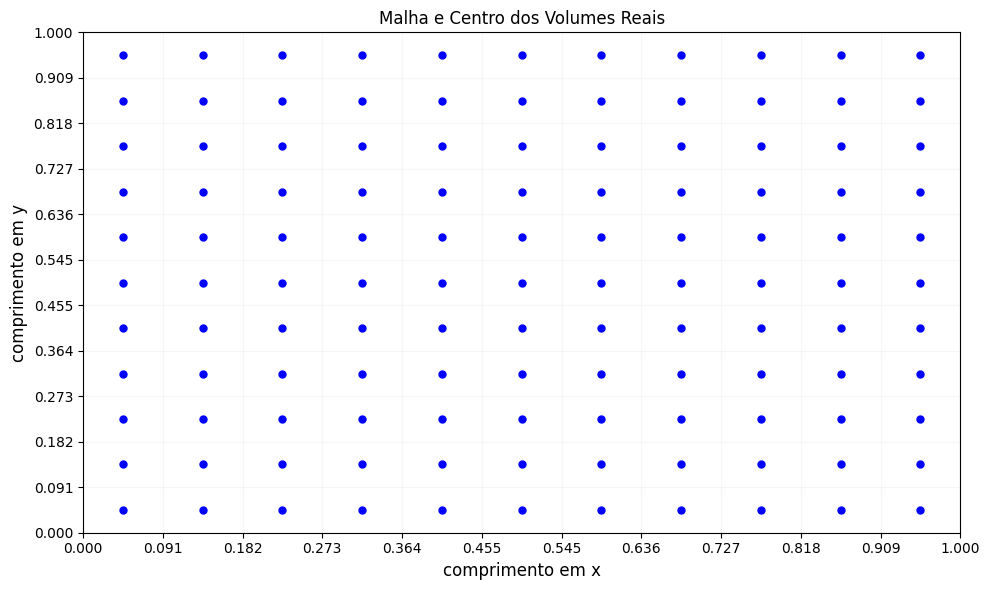

In [4]:
#Função para plotagem de gráficos
plt.figure(figsize=(10,6))
for i in range(0, len(x)):
    for k in range(0, len(y)):
        plt.plot(x[i], y[k], color='blue', linestyle='None', linewidth=2, marker='o', markersize=5)
plt.xticks(np.arange(0, 1 + 1/11, 1/11))
plt.yticks(np.arange(0, 1 + 1/11, 1/11))
plt.xlabel('comprimento em x', fontsize=12)
plt.ylabel('comprimento em y', fontsize=12)
plt.title('Malha e Centro dos Volumes Reais', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=.1)
plt.tight_layout()
#plt.savefig(titulo+'.png')
plt.show()

In [5]:
TempContornoNorte = np.sin(np.pi * x)

In [6]:
#Podemos criar uma matriz "Campo de temperatura" para armazenar os valores do contorno e, posteriormente, armazenar os valores internos calculados.
campoTemp = np.zeros((Nx, Ny)) #inicializa a matriz com zeros

Para gerar a matriz de coeficientes, podemos criar algumas funções, tais como:

In [12]:

def contornoOeste(tempContorno):
    aW = 0
    aE = 1
    aN = 0
    aS = 0
    aP = 1
    b = 2 * tempContorno
    return aP, aW, aE, aN, aS , b

def contornoLeste(tempContorno):
    aW = 1
    aE = 0
    aN = 0
    aS = 0
    aP = 1
    b = 2 * tempContorno
    return aP, aW, aE, aN, aS, b

def contornoNorte(tempContorno):
    aW = 0
    aE = 0
    aN = 1
    aS = 0
    aP = 1
    b = 2 * tempContorno
    return aP, aW, aE, aN, aS, b

def contornoNorte(tempContorno):
    aW = 0
    aE = 0
    aN = 0
    aS = 1
    aP = 1
    b = 2 * tempContorno
    return aP, aW, aE, aN, aS, b

def volumesInternos(tempContorno):
    aW = 1
    aE = 1
    aN = 1
    aS = 1
    aP = -4
    b = 0
    return aP, aW, aE, aN, aS, b

Para o cálculo da temperatura podemos criar uma função que calcula os coeficientes para cada um dos volumes e aloca os valores em uma única matriz, cujo solução será o campo de temperaturas em um dado instante de tempo:

In [11]:
coef = np.zeros((qtdadeVolumes, qtdadeVolumes)) #primeiro foi criado uma matriz apenas com zeros no formato final para receber os resultados
vector = np.zeros(qtdadeVolumes) #de forma semelhante foi criado um vetor apenas com zeros

In [ ]:
Tinicial = 0 #estimativa inicial

#para criação da matriz de coeficientes, adotamos o padrão de varredura da direita para a esquerda e de baixo para cima, começando no volume sul a oeste e terminando no volume norte a leste.

for j in range(0, Ny)::
    for i in range(0, Nx):
        
        if j == 1: #parede sul
            aP, aW, aE, aN, aS, b = contornoSul(Tx0)

        elif j == Ny - 1: #parede norte
            



In [ ]:
def calcMatriz(campoTemp): #função que gera a matriz de coeficientes e o vetor de resultados para um dado instante de tempo
    coef = np.zeros((Nx,Ny)) #primeiro foi criado uma matriz apenas com zeros no formato final para receber os resultados
    vector = np.zeros(N) #de forma semelhante foi criado um vetor apenas com zeros

    #calculando os coeficientes do primeiro volume
    Tp0 = campoInicial[0] #temperatura do primeiro volume
    Te0 = campoInicial[1] #temperatura do segundo volume (a leste do primeiro)
    ap, aw, ae, b = PrimeiroVolume(Tp0, Te0) #utilizando a função definida anterioramente, calculamos os coeficientes para gerar a equação do primeiro volume

    #alocamos os valores calculados na matriz geral de coeficientes
    coef[0,0] = ap
    coef[0,1] = -ae
    vector[0] = b

    #para os volumes internos, temos:
    for i in range(1,N-1): #iteração indo do segundo volume ao penúltimo volume
        Tp0 = campoInicial[i] #temperatura do volume que está sendo calculado
        Tw0 = campoInicial[i-1] #temperatura do volume a oeste
        Te0 = campoInicial[i+1] #temperatura a leste
        ap, aw, ae, b = VolumesInternos(Tp0, Tw0, Te0) #calculamos os coeficientes para todos os volumes internos

        #alocamos os valores calculados na matriz geral de coeficientes
        coef[i, i-1] = -aw
        coef[i, i] = ap
        coef[i, i+1] = -ae
        vector[i] = b

    #calculando os coeficientes do último volume
    Tp0 = campoInicial[-1] #temperatura do último volume
    Tw0 = campoInicial[-2] #temperatura do volume a oeste
    ap, aw, ae, b = UltimoVolume(Tp0, Tw0) #coeficiente do último volume

    #alocamos os valores calculados na matriz geral de coeficientes
    coef[-1,-2] = -aw
    coef[-1,-1] = ap
    vector[-1] = b

    return coef, vector #o resultado dessa função é a matriz de coeficientes e vetor de resultado para todos os volumes em um único instante de tempo.

In [29]:
def matrizSolver(coef, vector): #função que resolve a matriz de coeficientes para calcular as temperaturas, aqui foi utilizado o metodo TDMA, conforme solicitado no enunciado.
    # Converte para arrays numpy
    A = np.array(coef, dtype=float)
    d = np.array(vector, dtype=float)
    n = len(d)

    # Extrai as diagonais
    a = np.zeros(n)  # diagonal inferior
    b = np.zeros(n)  # diagonal principal
    c = np.zeros(n)  # diagonal superior

    for i in range(n):
        b[i] = A[i, i]
        if i < n - 1:
            c[i] = A[i, i + 1]
        if i > 0:
            a[i] = A[i, i - 1]

    # Arrays auxiliares
    c_linha = np.zeros(n - 1)
    d_linha = np.zeros(n)
    x = np.zeros(n)

    # Forward sweep (eliminação)
    c_linha[0] = c[0] / b[0]
    d_linha[0] = d[0] / b[0]

    for i in range(1, n - 1):
        denominador = b[i] - a[i] * c_linha[i - 1]
        c_linha[i] = c[i] / denominador
        d_linha[i] = (d[i] - a[i] * d_linha[i - 1]) / denominador

    # Último elemento
    d_linha[n - 1] = (d[n - 1] - a[n - 1] * d_linha[n - 2]) / (b[n - 1] - a[n - 1] * c_linha[n - 2])

    # Backward substitution (substituição reversa)
    x[n - 1] = d_linha[n - 1]
    for i in range(n - 2, -1, -1):
        x[i] = d_linha[i] - c_linha[i] * x[i + 1]

    return x

Com as funções de cálculos bem definidas podemos aplicá-las ao campo de temperaturas inicial do nosso problema:

In [30]:
#com as funções definidas para calcular a temperatura no próximo instante de tempo, podemos gerar uma matriz com as temperatura para todos os volumes em cada instante de tempo.
campoTemperatura = np.zeros((M+1,N)) #criamos uma matriz inicial preenchida apenas com zeros
T_inicial = T #alocamos em T_inicial a temperatura no instante T=0s que foi calculada anteriormente
campoTemperatura[0,:] = T_inicial #a primeira linha da matriz será a temperatura inicial
for i in range(1,M+1): #loop que preenche a matriz com os resultados
    coeficientes, vector = calcMatriz(T_inicial)
    temperatura = matrizSolver(coeficientes, vector) #calculamos a temperatura do próximo instante de tempo usando a temperatura do instante anterior
    campoTemperatura[i,:] = temperatura #alocamos as temperaturas calculadas na matriz
    T_inicial = temperatura #a temperatura calculada é o input para o calculo da proxima

In [31]:
#função para plotagem de 6 gráficos em uma única imagem
def plot2(campoTemperatura, yMax, tituloGrafico, xlabel, ylabel):
    plt.figure(figsize=(10,6))
    colors = plt.cm.autumn(np.linspace(0, 1, campoTemperatura.shape[0]))
    for i in range(0,campoTemperatura.shape[0]):
        plt.plot(x, campoTemperatura[i,:], label='t={t}s'.format(t=i*4), color=colors[i], linewidth=2, marker='o', markersize=5)
    plt.xticks(np.arange(0, 0.11, 0.01))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(tituloGrafico, fontsize=12)
    plt.xlim(0, .1)
    plt.ylim(0, yMax)
    plt.grid(True, alpha=.1)
    plt.legend()
    plt.tight_layout()
    plt.savefig(tituloGrafico+'.png')
    plt.show()

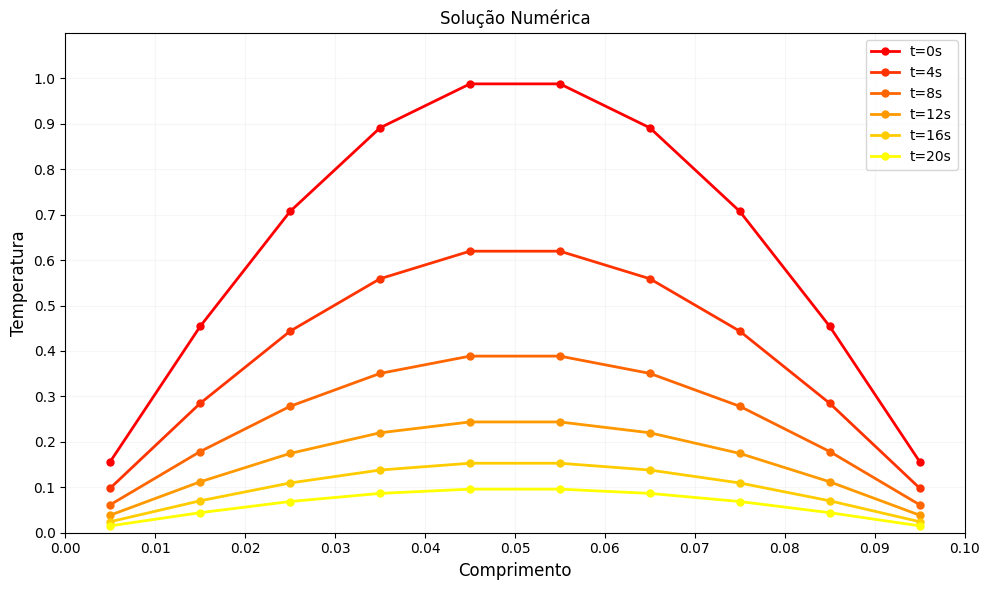

In [32]:
plot2(campoTemperatura, 1.1, 'Solução Numérica', 'Comprimento', 'Temperatura')

In [33]:
#calculo temperatura média usando regra do trapézio
def calcTempMediaNum(campoTemperatura, deltaX):
    tempMedia = np.zeros(campoTemperatura.shape[0])
    for i in range(0, tempMedia.shape[0]):
        integral = deltaX * (campoTemperatura[i, 0]/2 + np.sum(campoTemperatura[i, 1:-1]) + campoTemperatura[i, -1]/2)
        tempMedia[i] = integral / L
    return tempMedia

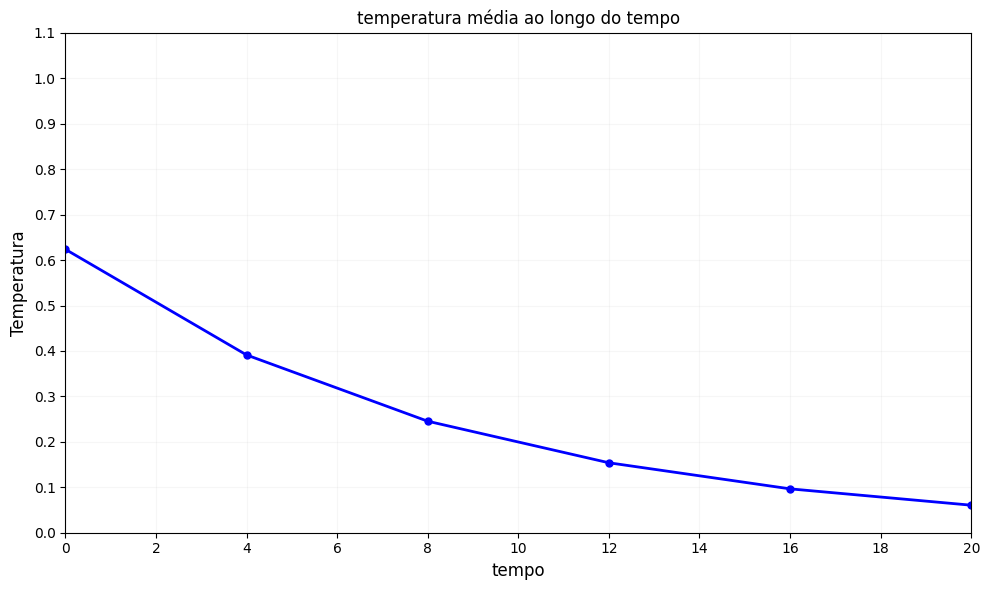

In [34]:
tempMediaNum = calcTempMediaNum(campoTemperatura, deltaX)
plot1(tempMediaNum, timeStep, timeStep[-1], 1.1, 'temperatura média ao longo do tempo', 'tempo', 'Temperatura')

Para comparação do resultados podemos calcular a solução analítica do problema:

In [35]:
#solução analítica
T_analitico = np.zeros((M+1,N))
for i in range(0,M+1):
    t = i * deltaT
    T_analitico[i,:] = np.sin(np.pi * x / L) * (np.e ** (- alpha * ((np.pi / L)**2) * t))

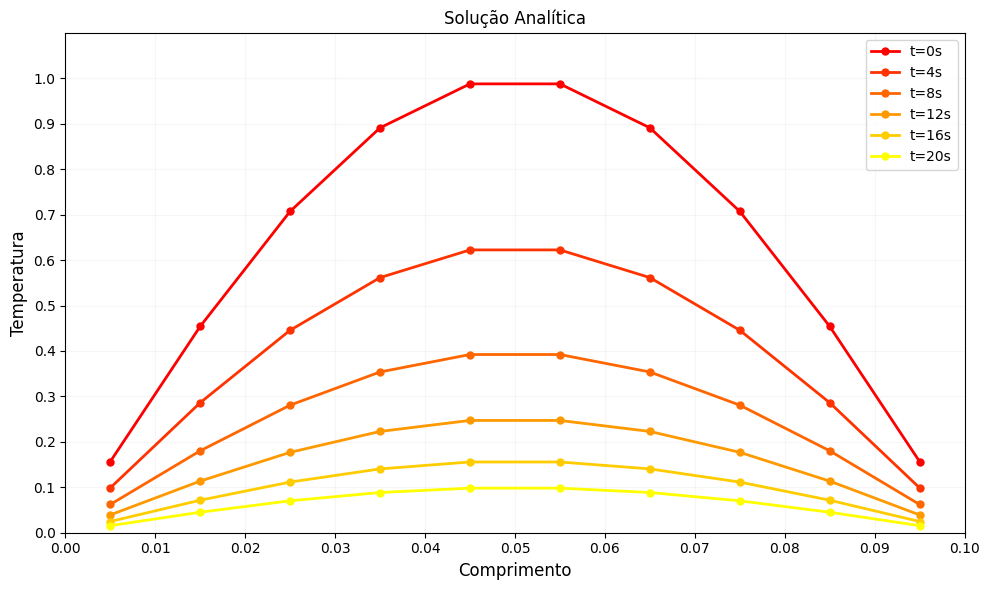

In [36]:
plot2(T_analitico, 1.1, 'Solução Analítica', 'Comprimento', 'Temperatura')

In [37]:
#calculo temperatura média analítica
def calcTempMediaAnalitica(t, L, alpha):
    TmediaAnalitica = (2 / np.pi) * np.exp(-alpha * (np.pi / L)**2 * t)
    return TmediaAnalitica

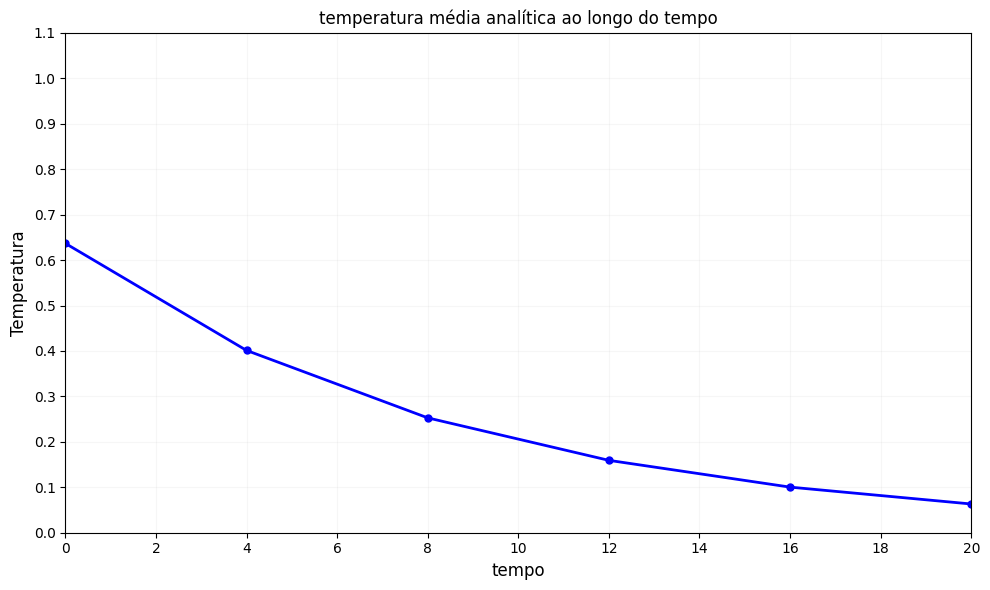

In [38]:
tempMediaAnalitica = calcTempMediaAnalitica(timeStep, L, alpha)
plot1(tempMediaAnalitica, timeStep, timeStep[-1], 1.1, 'temperatura média analítica ao longo do tempo', 'tempo', 'Temperatura')

Sabendo a solução analítica podemos calcular o erro da nossa solução numérica em cada um dos volumes e em cada instante de tempo:

In [39]:
Erro = T_analitico - campoTemperatura

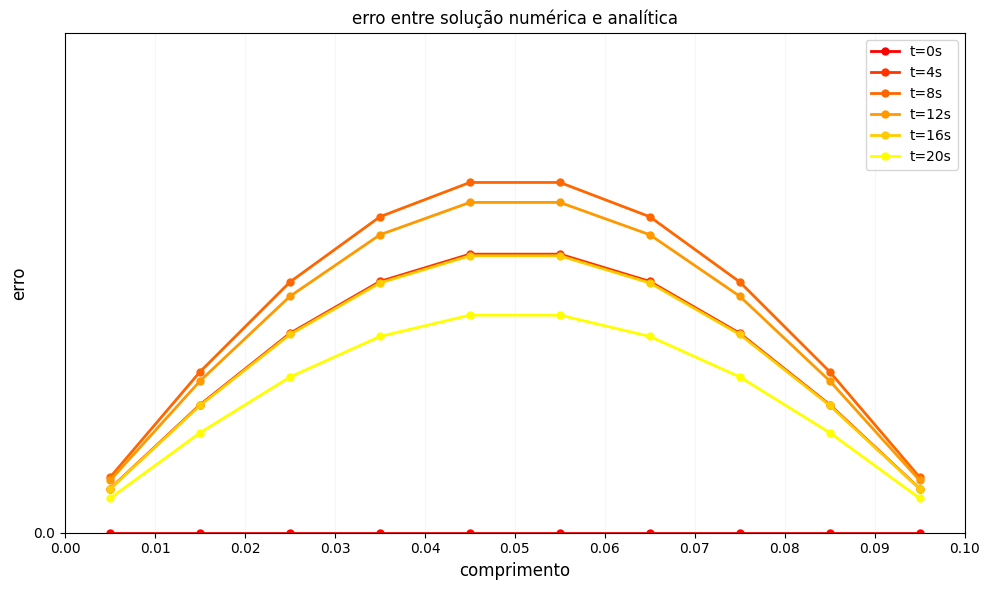

In [40]:
plot2(Erro, 0.005, 'erro entre solução numérica e analítica', 'comprimento', 'erro')

APRESENTAÇÃO DOS RESULTADOS CONFORME SOLICITADO PELO ENUNCIADO:

In [41]:
#ITEM 1
volumeIndex = np.array(range(1,N+1))

item1data = {
    'volume: ': tuple(volumeIndex),
    'Xp: ': tuple(x),
    'Tp analítico: ': tuple(T_analitico[-1]),
    'Tp numérico: ': tuple(campoTemperatura[-1,:]),
    'Erro: ': tuple(Erro[-1]),
}

df1 = pd.DataFrame(item1data)
pd.options.display.float_format = '{:.10f}'.format
df1

,volume:,Xp:,Tp analítico:,Tp numérico:,Erro:
0,1,0.0050000000,0.0155358420,0.0151911455,0.0003446964
1,2,0.0150000000,0.0450867694,0.0440864214,0.0010003481
2,3,0.0250000000,0.0702242897,0.0686662111,0.0015580786
3,4,0.0350000000,0.0884877673,0.0865244737,0.0019632936
4,5,0.0450000000,0.0980894457,0.0959131180,0.0021763277
5,6,0.0550000000,0.0980894457,0.0959131180,0.0021763277
6,7,0.0650000000,0.0884877673,0.0865244737,0.0019632936
7,8,0.0750000000,0.0702242897,0.0686662111,0.0015580786
8,9,0.0850000000,0.0450867694,0.0440864214,0.0010003481
9,10,0.0950000000,0.0155358420,0.0151911455,0.0003446964


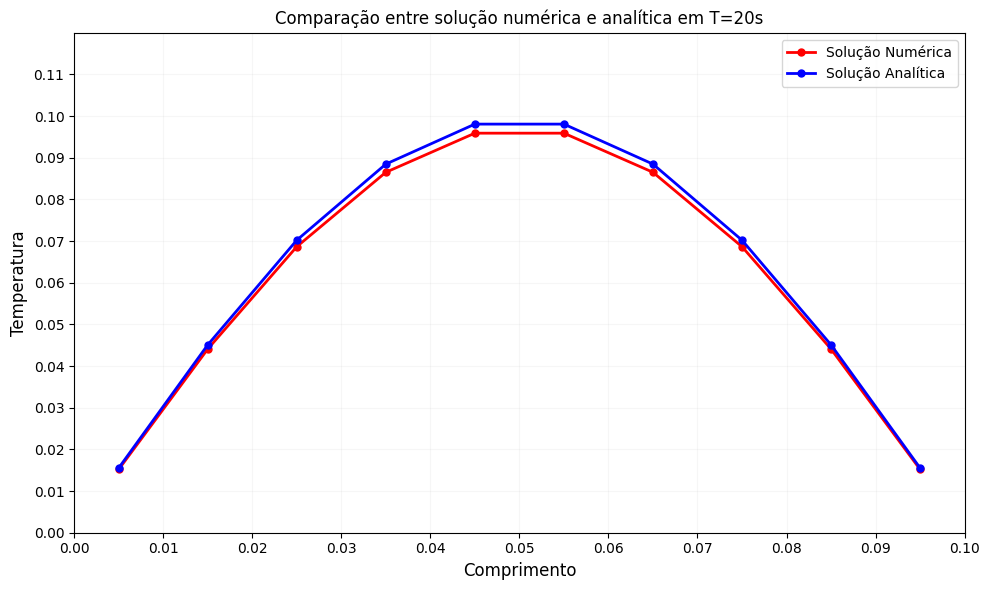

In [42]:
#ITEM 2

plt.figure(figsize=(10,6))
plt.plot(x, campoTemperatura[-1,:], label='Solução Numérica', color='red', linewidth=2, marker='o', markersize=5)
plt.plot(x, T_analitico[-1,:], label='Solução Analítica', color='blue', linewidth=2, marker='o', markersize=5)
plt.xticks(np.arange(0, 0.11, 0.01))
plt.yticks(np.arange(0, 0.12, 0.01))
plt.xlabel('Comprimento', fontsize=12)
plt.ylabel('Temperatura', fontsize=12)
plt.title('Comparação entre solução numérica e analítica em T=20s', fontsize=12)
plt.xlim(0, .1)
plt.ylim(0, .12)
plt.grid(True, alpha=.1)
plt.legend()
plt.tight_layout()
plt.savefig('Comparação entre solução numérica e analítica em T=20s'+'.png')
plt.show()

In [43]:
#ITEM 3

erroTempMedia = tempMediaAnalitica - tempMediaNum

item3data = {
    'tempo: ': tuple(timeStep),
    'temperatura média analítica: ': tuple(tempMediaAnalitica),
    'temperatura média numérica: ': tuple(tempMediaNum),
    'erro: ': tuple(erroTempMedia),
}
df3 = pd.DataFrame(item3data)
pd.options.display.float_format = '{:.10f}'.format
df3

,tempo:,temperatura média analítica:,temperatura média numérica:,erro:
0,0.0000000000,0.6366197724,0.6236018756,0.0130178967
1,4.0000000000,0.4011257976,0.3911641357,0.0099616618
2,8.0000000000,0.2527441221,0.2453638885,0.0073802336
3,12.0000000000,0.1592507678,0.1539083783,0.0053423895
4,16.0000000000,0.1003418273,0.0965414636,0.0038003637
5,20.0000000000,0.0632240738,0.0605571594,0.0026669145


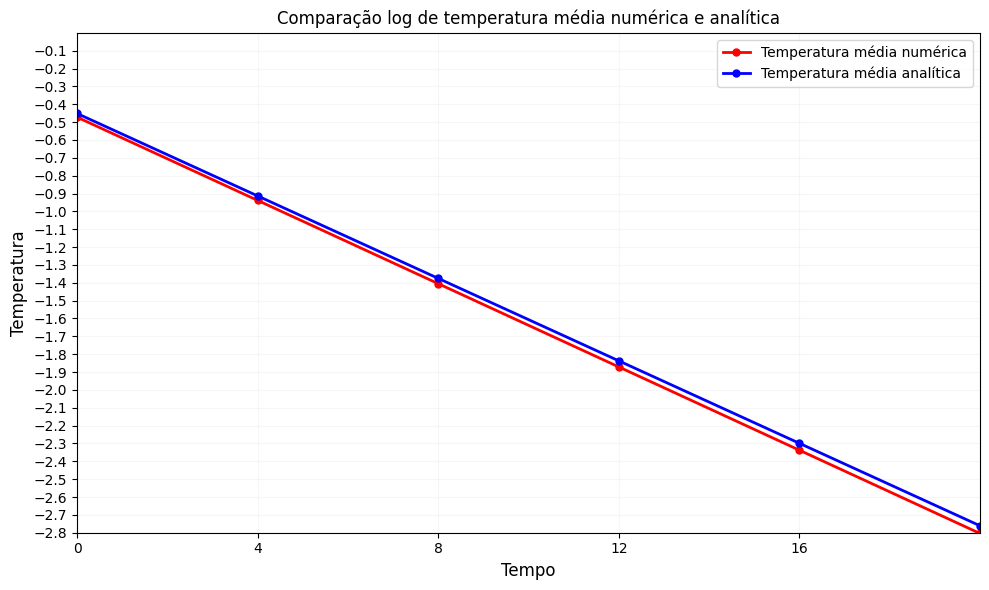

In [ ]:
#ITEM 4

plt.figure(figsize=(10,6))
plt.plot(timeStep, np.log(tempMediaNum), label='Temperatura média numérica', color='red', linewidth=2, marker='o', markersize=5)
plt.plot(timeStep, np.log(tempMediaAnalitica), label='Temperatura média analítica', color='blue', linewidth=2, marker='o', markersize=5)
plt.xticks(np.arange(0, timeStep[-1], 4))
plt.yticks(np.arange(-2.8, 0, 0.1))
plt.xlabel('Tempo', fontsize=12)
plt.ylabel('Temperatura', fontsize=12)
plt.title('Comparação log de temperatura média numérica e analítica', fontsize=12)
plt.xlim(0, timeStep[-1])
plt.ylim(-2.8, 0)
plt.grid(True, alpha=.1)
plt.legend()
plt.tight_layout()
plt.savefig('Comparação log de temperatura média numérica e analítica'+'.png')
plt.show()